# Code derived from: [A high resolution model of the grapevine leaf morphospace predicts synthetic leaves](https://doi.org/10.1002/ppp3.10561)

_______

# IMPORT MODULES

In [1]:
# import modules and functions

import matplotlib.pyplot as plt
from pylab import *
import math
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import interp1d # for interpolating points
from scipy.signal import find_peaks # for peak detection
from sklearn.decomposition import PCA # for principal component analysis
from scipy.optimize import curve_fit # for fitting curves
from scipy.spatial import procrustes # for Procrustes analysis
from os import listdir # for retrieving files from directory
from os.path import isfile, join # for retrieving files from directory
import os # for retrieving files from directory
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # for LDA
from sklearn.metrics import confusion_matrix # for confusion matrix
from scipy.spatial import ConvexHull # for convex hulls
from matplotlib.patches import Rectangle
from matplotlib.path import Path
from numpy.linalg import det # for sampling higher dimensional convex hull
from scipy.stats import dirichlet
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay
from sklearn.model_selection import StratifiedKFold
import pickle # for saving compressed files
import h5py # for saving compressed files
from sklearn.neighbors import NearestNeighbors # For finding k-nearest neighbors


# DEFINE FUNCTIONS

In [2]:
# define functions

def angle_between(p1, p2, p3):
    """
    define a function to find the angle between 3 points anti-clockwise in degrees, p2 being the vertex
    inputs: three angle points, as tuples
    output: angle in degrees
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(math.atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(math.atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

def rotate_points(xvals, yvals, degrees):
    """"
    define a function to rotate 2D x and y coordinate points around the origin
    inputs: x and y vals (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
    outputs: rotated and y vals
    """
    angle_to_move = 270 - degrees
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals

def interpolation(x, y, number): 
    """
    define a function to return equally spaced, interpolated points for a given polyline
    inputs: arrays of x and y values for a polyline, number of points to interpolate
    ouputs: interpolated points along the polyline, inclusive of start and end points
    """
    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, number)
    x_regular, y_regular = fx(alpha), fy(alpha)
    
    return x_regular, y_regular

def euclid_dist(x1, y1, x2, y2):
    """
    define a function to return the euclidean distance between two points
    inputs: x and y values of the two points
    output: the eulidean distance
    """
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def detect_landmark(vein,tip_indices,start_ind,end_ind,ref_ind,use_forward=True,use_max=True):
    """
    define a function to find index of farthest/closest point from ref index point for a set of vein coordinates
    inputs: 2D array of vein points, rows are points columns x and y coordinate values,
    indices of tips, start index, end index, reference idex
    if use_forward=True, then should be used on the forward side of the leaf, otherwise the reverse
    if use_max=True, then finds furthest point from ref, otherwise closest
    ouputs: index of the farthest/closest point from reference
    dependencies: uses the funciton euclid_dist
    """
    ref_dist = [] # store distances to end index 
    dist_ind = [] # store indices for each distance
    if use_forward==True:
        for i in range(start_ind+1, end_ind):
            ref_dist.append(euclid_dist(vein[ref_ind,0],vein[ref_ind,1],vein[i,0],vein[i,1]))
            dist_ind.append(i)
    else:
        for i in range(end_ind+1, start_ind):
            ref_dist.append(euclid_dist(vein[ref_ind,0],vein[ref_ind,1],vein[i,0],vein[i,1]))
            dist_ind.append(i)
    if use_max==True:  
        max_dist_ind = ref_dist.index(max(ref_dist))
        pt_ind = dist_ind[max_dist_ind]
    else:
        min_dist_ind = ref_dist.index(min(ref_dist))
        pt_ind = dist_ind[min_dist_ind]
    return pt_ind
    
def internal_landmarks(vein,tip_indices):
    """
    define a function to return indices of internal vein landmarks given vein tip indices
    inputs: 2D array of vein points, rows are points columns x and y coordinate values,
    indices of tips
    ouputs: a list of indices of internal vein landmarks
    dependencies: detect_landmark
    """
    ### FORWARD SIDE OF LEAF
    
    ### PROXIMAL LOBE
    ### POINT B, 1
    ptB_ind = detect_landmark(vein,tip_indices,tip_indices[1],tip_indices[2],tip_indices[2],use_forward=True,use_max=True)
    ### POINT A, 2
    ptA_ind = detect_landmark(vein,tip_indices,tip_indices[0],tip_indices[1],ptB_ind,use_forward=True,use_max=False)
    ### POINT D, 3
    ptD_ind = detect_landmark(vein,tip_indices,tip_indices[2],tip_indices[3],tip_indices[3],use_forward=True,use_max=True)
    ### POINT C, 4
    ptC_ind = detect_landmark(vein,tip_indices,tip_indices[1],tip_indices[2],ptD_ind,use_forward=True,use_max=False)
    ### POINT F, 5
    ptF_ind = detect_landmark(vein,tip_indices,tip_indices[3],tip_indices[4],tip_indices[4],use_forward=True,use_max=True)
    ### POINT E, 6
    ptE_ind = detect_landmark(vein,tip_indices,tip_indices[2],tip_indices[3],ptF_ind,use_forward=True,use_max=False)
    ### POINT G, 7
    ptG_ind = detect_landmark(vein,tip_indices,tip_indices[4],tip_indices[5],tip_indices[5],use_forward=True,use_max=True)

    ### DISTAL LOBE
    ### POINT I, 8
    ptI_ind = detect_landmark(vein,tip_indices,tip_indices[5],tip_indices[6],tip_indices[6],use_forward=True,use_max=True)
    ### POINT H, 9
    ptH_ind = detect_landmark(vein,tip_indices,tip_indices[4],tip_indices[5],ptI_ind,use_forward=True,use_max=False)
    ### POINT K, 10
    ptK_ind = detect_landmark(vein,tip_indices,tip_indices[6],tip_indices[7],tip_indices[7],use_forward=True,use_max=True)
    ### POINT J, 11
    ptJ_ind = detect_landmark(vein,tip_indices,tip_indices[5],tip_indices[6],ptK_ind,use_forward=True,use_max=False)
    ### POINT M, 12
    ptM_ind = detect_landmark(vein,tip_indices,tip_indices[7],tip_indices[8],tip_indices[8],use_forward=True,use_max=True)
    ### POINT L, 13
    ptL_ind = detect_landmark(vein,tip_indices,tip_indices[6],tip_indices[7],ptM_ind,use_forward=True,use_max=False)
    ### POINT N, 14
    ptN_ind = detect_landmark(vein,tip_indices,tip_indices[8],tip_indices[9],tip_indices[9],use_forward=True,use_max=True)
    
    ### MIDVEIN
    ### POINT P, 15
    ptP_ind = detect_landmark(vein,tip_indices,tip_indices[9],tip_indices[10],tip_indices[10],use_forward=True,use_max=True)
    ### POINT O, 16
    ptO_ind = detect_landmark(vein,tip_indices,tip_indices[8],tip_indices[9],ptP_ind,use_forward=True,use_max=False)
    ### POINT R, 17
    ptR_ind = detect_landmark(vein,tip_indices,tip_indices[10],tip_indices[11],tip_indices[11],use_forward=True,use_max=True)
    ### POINT Q, 18
    ptQ_ind = detect_landmark(vein,tip_indices,tip_indices[9],tip_indices[10],ptR_ind,use_forward=True,use_max=False)
    ### POINT T, 19
    ptT_ind = detect_landmark(vein,tip_indices,tip_indices[11],tip_indices[12],tip_indices[12],use_forward=True,use_max=True)
    ### POINT S, 20
    ptS_ind = detect_landmark(vein,tip_indices,tip_indices[10],tip_indices[11],ptT_ind,use_forward=True,use_max=False)

    ### REVERSE SIDE OF LEAF
    
    ### PROXIMAL LOBE
    ### POINT zB
    ptzB_ind = detect_landmark(vein,tip_indices,tip_indices[-2],tip_indices[-3],tip_indices[-3],use_forward=False,use_max=True)
    ### POINT zA
    ptzA_ind = detect_landmark(vein,tip_indices,tip_indices[-1],tip_indices[-2],ptzB_ind,use_forward=False,use_max=False)
    ### POINT zD
    ptzD_ind = detect_landmark(vein,tip_indices,tip_indices[-3],tip_indices[-4],tip_indices[-4],use_forward=False,use_max=True)
    ### POINT zC
    ptzC_ind = detect_landmark(vein,tip_indices,tip_indices[-2],tip_indices[-3],ptzD_ind,use_forward=False,use_max=False)
    ### POINT zF
    ptzF_ind = detect_landmark(vein,tip_indices,tip_indices[-4],tip_indices[-5],tip_indices[-5],use_forward=False,use_max=True)
    ### POINT zE
    ptzE_ind = detect_landmark(vein,tip_indices,tip_indices[-3],tip_indices[-4],ptzF_ind,use_forward=False,use_max=False)
    ### POINT zG
    ptzG_ind = detect_landmark(vein,tip_indices,tip_indices[-5],tip_indices[-6],tip_indices[-6],use_forward=False,use_max=True)

    ### DISTAL LOBE
    ### POINT zI
    ptzI_ind = detect_landmark(vein,tip_indices,tip_indices[-6],tip_indices[-7],tip_indices[-7],use_forward=False,use_max=True)
    ### POINT zH
    ptzH_ind = detect_landmark(vein,tip_indices,tip_indices[-5],tip_indices[-6],ptzI_ind,use_forward=False,use_max=False)
    ### POINT zK
    ptzK_ind = detect_landmark(vein,tip_indices,tip_indices[-7],tip_indices[-8],tip_indices[-8],use_forward=False,use_max=True)
    ### POINT zJ
    ptzJ_ind = detect_landmark(vein,tip_indices,tip_indices[-6],tip_indices[-7],ptzK_ind,use_forward=False,use_max=False)
    ### POINT zM
    ptzM_ind = detect_landmark(vein,tip_indices,tip_indices[-8],tip_indices[-9],tip_indices[-9],use_forward=False,use_max=True)
    ### POINT zL
    ptzL_ind = detect_landmark(vein,tip_indices,tip_indices[-7],tip_indices[-8],ptzM_ind,use_forward=False,use_max=False)
    ### POINT zN
    ptzN_ind = detect_landmark(vein,tip_indices,tip_indices[-9],tip_indices[-10],tip_indices[-10],use_forward=False,use_max=True)

    ### MIDVEIN
    ### POINT zP
    ptzP_ind = detect_landmark(vein,tip_indices,tip_indices[-10],tip_indices[-11],tip_indices[-11],use_forward=False,use_max=True)
    ### POINT zO
    ptzO_ind = detect_landmark(vein,tip_indices,tip_indices[-9],tip_indices[-10],ptzP_ind,use_forward=False,use_max=False)
    ### POINT zR
    ptzR_ind = detect_landmark(vein,tip_indices,tip_indices[-11],tip_indices[-12],tip_indices[-12],use_forward=False,use_max=True)
    ### POINT zQ
    ptzQ_ind = detect_landmark(vein,tip_indices,tip_indices[-10],tip_indices[-11],ptzR_ind,use_forward=False,use_max=False)
    ### POINT zT
    ptzT_ind = detect_landmark(vein,tip_indices,tip_indices[-12],tip_indices[-13],tip_indices[-13],use_forward=False,use_max=True)
    ### POINT zS
    ptzS_ind = detect_landmark(vein,tip_indices,tip_indices[-11],tip_indices[-12],ptzT_ind,use_forward=False,use_max=False)
    
    landmark_indices = [ptA_ind,ptB_ind,ptC_ind,ptD_ind,ptE_ind,ptF_ind,ptG_ind,ptH_ind,ptI_ind,ptJ_ind,
             ptK_ind,ptL_ind,ptM_ind,ptN_ind,ptO_ind,ptP_ind,ptQ_ind,ptR_ind,ptS_ind,ptT_ind,
             ptzT_ind,ptzS_ind,ptzR_ind,ptzQ_ind,ptzP_ind,ptzO_ind,ptzN_ind,ptzM_ind,ptzL_ind,ptzK_ind,
             ptzJ_ind,ptzI_ind,ptzH_ind,ptzG_ind,ptzF_ind,ptzE_ind,ptzD_ind,ptzC_ind,ptzB_ind,ptzA_ind
            ]
    
    return landmark_indices

def interpolated_intervals(land_indices, new_xvals, new_yvals, num_land):
    
    """
    define a function to return interpolated points for each interval between landmarks of a trace file
    inputs: landmark indices, xvals and yvals of polyline at desired resolution,
    number of interpolated landmarks per interval
    outputs: lists of x and y values with specified number of interpolated points per interval
    dependencies: interpolation
    """
    
    inter_points_x = [] # list to store interpolated x vals
    inter_points_y = [] # list to store interpolated y vals

    for i in range(len(land_indices)-1): # for each index, minus 1, because we are analyzing intervals

        beg_ind = land_indices[i] # specify the beginning point, based on index
        end_ind = land_indices[i+1] # specify the end point, based on index

        interval_xvals = new_xvals[beg_ind:end_ind] # using indices above, find the interval of x vals
        interval_yvals = new_yvals[beg_ind:end_ind] # using indices above, find the interval of y vals

        curr_inter_xvals, curr_inter_yvals = interpolation(interval_xvals, interval_yvals, num_land) # interpolate the interval

        curr_inter_xvals = list(curr_inter_xvals) # convert interval x vals into a list
        curr_inter_yvals = list(curr_inter_yvals) # convert interval y vals into a list

        # to prevent duplicated pseudo-landmark points, because we are working with intervals:

        if i==0: # if the first interval, delete the end point, because it will be covered in the next interval

            del curr_inter_xvals[-1]
            del curr_inter_yvals[-1]

        if i!=0: # if not the first interval, delete the start point, because it was covered in the previous interval

            del curr_inter_xvals[0]
            del curr_inter_yvals[0]

        for j in range(len(curr_inter_xvals)): # for the current interval points

            inter_points_x.append(curr_inter_xvals[j]) # append current interval x vals to list
            inter_points_y.append(curr_inter_yvals[j]) # append current interval y vals to list

    return inter_points_x, inter_points_y

def rotate_and_scale(vein_xvals, vein_yvals, blade_xvals, blade_yvals, base_ind, tip_ind, end_ind, px2_cm2):
    """
    define a function to rotate tip downwards, scale to centimeters, and translate petiolar junction to the origin
    inputs: interpolated x and y vein and blade values, base(first), tip, and end indices, and px2 to cm2 scale
    outputs: rotated, scaled, and translated landmark, vein, and blade coordinates
    dependencies: PCA from sklearn, rotate_points
    """
    vein_arr = np.column_stack((vein_xvals, vein_yvals)) # create vein coordinates array
    blade_arr = np.column_stack((blade_xvals, blade_yvals)) # create blade coordinates array

    vein_len = np.shape(vein_arr)[0] # get lengths of vein and blade arrays to retrieve coords later
    blade_len = np.shape(blade_arr)[0]
    overall_len = vein_len + blade_len

    overall_arr = np.row_stack((vein_arr, blade_arr)) # stack vein and blade arrays into single array

    px_cm = np.sqrt(px2_cm2) # take square root of scaling factor to scale pixels to cm
    scaled_arr = overall_arr/px_cm # convert pixels into cm
    tip_to_base_cm = np.sqrt((scaled_arr[tip_ind,0]-scaled_arr[base_ind,0])**2  # get distance in pixels from tip to base of leaf
                             + (scaled_arr[tip_ind,1]-scaled_arr[base_ind,1])**2) # use to scale PC values back to cm later
    
    # perform a principal component analysis on data to center
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(overall_arr)
    df = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
    
    # find the angle of the leaf tip relative to the origin
    
    p1 = (df["pc1"].loc[tip_ind,], df["pc2"].loc[tip_ind,]) # get leaf tip PC1/PC2 coordinate value
    p2 = (0,0) # find angle relative to vertex at origin
    p3 = (10,0) # an arbitrary positive point along the x axis to find angle in anticlockwise direction

    angle = angle_between(p1, p2, p3) # find the angle in degrees of tip point relative to origin, anticlockwise

    rotated_xvals, rotated_yvals = rotate_points(df["pc1"], df["pc2"], angle)

    rotated_arr = np.column_stack((rotated_xvals, rotated_yvals)) # stack x and y vals back into one array

    tip_to_base_pca = np.sqrt((rotated_arr[tip_ind,0]-rotated_arr[base_ind,0])**2 # find the distance in PC vals between tip and base
                              + (rotated_arr[tip_ind,1]-rotated_arr[base_ind,1])**2)

    scale = tip_to_base_cm/tip_to_base_pca # find the factor to scale back to cm

    scaled_arr = rotated_arr*scale # scale rotated PC vals back to cm
    
    pet_junc = np.mean(scaled_arr[[base_ind,end_ind],:],axis=0)
    
    trans_x = scaled_arr[:,0] - pet_junc[0]
    trans_y = scaled_arr[:,1] - pet_junc[1]
    
    scaled_arr = np.column_stack((trans_x, trans_y))
    
    if scaled_arr[10,0] < 0: # insure left side of the leaf is left so labels are on right side of plot
        scaled_arr[:,0] = -scaled_arr[:,0]

    scaled_vein = scaled_arr[0:vein_len,] # isolate just vein coords
    scaled_blade = scaled_arr[vein_len:(vein_len+blade_len),] # isolate just blade coords

    return scaled_vein, scaled_blade # return scaled and rotated vein and blade

def PolyArea(x,y):
    """
    define a function to calculate the area of a polygon using the shoelace algorithm
    inputs: separate numpy arrays of x and y coordinate values
    outputs: the area of the polygon
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def calc_gpa_mean(shape_arr, num_pseuds, num_coords):
    """
    input: a 3D array of shapes, shapes x num_pseuds landmarks x num_coords coordinates
    output: a generalized Procrustes mean
    """
    
    shape_list = shape_arr # using an array instead of list, rename variable input
    
    ref_ind = 0 # select a reference index to calculate procrustes distances to
    ref_shape = shape_list[ref_ind] # select the reference shape

    mean_diff = 10**(-30) # set a distance between means to stop the algorithm

    old_mean = ref_shape # for the first comparison between means, set old_mean to an arbitrary reference shape

    d = 1000000 # set d initially arbitraily high

    while d > mean_diff: # set boolean criterion for Procrustes distance between mean to stop calculations

        arr = np.zeros( ((len(shape_list)),num_pseuds,num_coords) ) # empty 3D array: # samples, 21 landmarks, 2 coord vals

        for i in range(len(shape_list)): # for each leaf shape after removing outliers

            s1, s2, distance = procrustes(old_mean, shape_list[i]) # calculate procrustes adjusted shape to ref for current leaf
            arr[i] = s2 # store procrustes adjusted shape to array

        new_mean = np.mean(arr, axis=(0)) # calculate mean of all shapes adjusted to reference

        s1, s2, d = procrustes(old_mean, new_mean) # calculate procrustes distance of new mean to old mean

        old_mean = new_mean # set the old_mean to the new_mea before beginning another iteration

    gpa_mean = new_mean
    
    return gpa_mean


# READ IN DATA AND CREATE LIST OF LEAF IDENTIFIERS

For each leaf, starting on one side of the petiolar junction, in ImageJ/Fiji (Schindelin et al., 2012; Schneider et al., 2012) a trace of the vein and blade was made using the line segment tool and stored as a .txt file. An information file, storing species/variety name, the dataset the leaf scan originated from, the vine, developmental stage, file name of the associated image, dataset source, and scaling information, was stored as a .csv file. All three files have a three digit identifier indicating if they are from the Wolfskill/Geneva dataset (starting with "0") or the UC Davis vineyard dataset traced by MSU (starting with "1") or UC Davis (starting with "2) students seprated by underscore and followed by the species/variety name in capital letters. Another underscore separates an identifier indicating if the file is a blade or vein trace or information file ("blade", "vein", and "info", respectively). File names from a data folder were read in and used to store raw data and assocaited labels using the file names.

In [3]:
data_dir = "../data" # set data directory - MODIFIED PATH

file_names = [f for f in listdir(data_dir) if isfile(join(data_dir, f))] # create a list of file names

# Removed .DS_Store file handling as it's better to handle it during data preparation or with a more robust check if it's always present.
# If .DS_Store is consistently present and needs removal, we can add it back with a check.
if '.DS_Store' in file_names:
    file_names.remove('.DS_Store') # remove .DS_Store file

file_names.sort() # sort the list of file names

duplicate_leaf_list = [] # store leaf identifiers, they will be duplicated
for i in range(len(file_names)): # for each file
    last_us = file_names[i].rindex("_") # get the last underscore position
    leaf_name = file_names[i][:last_us] # get the leaf identifier
    duplicate_leaf_list.append(leaf_name) # store leaf ID in duplicate_leaf_list
    
leaf_list = [] # a non-duplicated list of leaf identifiers
for i in duplicate_leaf_list: # for each leaf ID in the duplicated list
    if i not in leaf_list: # if it is not already in the unique list
        leaf_list.append(i) # append to the unique list
        
label_list = [] # create a label_list of leaf classes

for i in range(len(leaf_list)):

    leaf_name = leaf_list[i] # get the current leaf name

    # The original code used file_names[i].index("_") for leaf_ID extraction,
    # which would be incorrect as file_names contains all individual image files,
    # while leaf_list contains unique leaf identifiers.
    # We should use leaf_name itself for extraction.
    first_us = leaf_name.index("_") # get the first underscore position of the leaf_name
    leaf_ID = leaf_name[:first_us] # get just the 3 numeral ID of the leaf name
    leaf_num = int(leaf_ID) # convert the leaf_ID into an int
    first_num = leaf_ID[0] # get first number (string) of leaf_ID

    # IDENTIFY ORIGINAL VINIFERA AND WILD LEAVES
    if first_num=="0" and leaf_num==0:
        if leaf_name[4]!="V":
            label_list.append("vinifera")
        elif leaf_name[4]=="V":
            label_list.append("wild")
            
    # IDENTIFY ORIGINAL LEAVES HIGH ERROR    
    elif first_num=="0" and (leaf_num>0 and leaf_num<=17):
        label_list.append("error")
        
    # IDENTIFY ORIGINAL LEAVES USED FOR DEVELOPMENTAL SERIES
    elif first_num=="0" and (leaf_num>=18 and leaf_num<=57):
        if "leaf1" in leaf_name:
            label_list.append("leaf1")
        elif "leaf2" in leaf_name:
            label_list.append("leaf2")
        elif "leaf3" in leaf_name:
            label_list.append("leaf3")
        elif "leaf4" in leaf_name:
            label_list.append("leaf4")
    
    # IDENTIFY MICHIGAN STATE UNIVERSITY LEAVES
    elif first_num=="1":
        label_list.append("MSU")
        
    # IDENTIFY UNIVERSITY OF CALIFORNIA DAVIS LEAVES
    elif first_num=="2":
        label_list.append("UC Davis")

    # IDENTIFY ALGERIA LEAVES
    elif first_num=="3":
        label_list.append("Algeria")
            
    else:
        label_list.append("NA")


# print out leaf and label lists to check
for i in range(len(leaf_list)):
    print(label_list[i], leaf_list[i])

vinifera 000_ALICANTEBOUSCHET
vinifera 000_CABERNETSAUVIGNON
vinifera 000_CHARDONNAY
vinifera 000_CHASSELASCIOUTAT
vinifera 000_CHASSELASDORE
vinifera 000_FLAMETOKAY
vinifera 000_GEWURTZTRAMINER
vinifera 000_PINOTNOIR
vinifera 000_SYLVANER
vinifera 000_SYRAH
wild 000_VITISACERIFOLIA
wild 000_VITISAESTIVALIS
wild 000_VITISAMURENSIS
wild 000_VITISCINEREA
wild 000_VITISCOIGNETIAE
wild 000_VITISLABRUSCA
wild 000_VITISPALMATA
wild 000_VITISPIASEZKII
wild 000_VITISRIPARIA
wild 000_VITISRUPESTRIS
wild 000_VITISTHUNBERGII
wild 000_VITISVULPINA
vinifera 000_WHITERIESLING
vinifera 000_ZINFANDEL
error 001_leaf4_588147a
error 002_leaf1_wGVIT1627a
error 003_leaf5_588147a
error 004_leafb_K1164A
error 005_leafc_K1163A
error 006_leaf2_483180a
error 007_leaf8_w588055a
error 008_leaf2_wGVIT1626a
error 009_leaf10_wGVIT1626b
error 010_leaf2_483186a
error 011_leaf11_597257a
error 012_leafd_K1163A
error 013_leaf6_wGVIT1627a
error 014_leaf3_588538a
error 015_leaf1_279897a
error 016_leaf9_588174a
error 017_le

# FIND LANDMARKS

90 landmarks (25 from the vein tips, 40 internal vein landmarks, and 25 blade landmarks) were automatically detected from the vein and blade trace files. Vein and blade traces were interpolated with 1000 equidistantly spaced points to increase the resolution of the data using the interp1d function SciPy (Virtanen et al., 2020). The petiolar junction was calculated as the mean of the first ("a) and last ("y") coordinate in the vein trace file. The Euclidean distance of each vein trace point to the petiolar junction was calculated as a function of geodesic distance along the trace itself (or the index of each point, as points are equidistantly placed along the trace). The SciPy find_peaks function was used to find the 25 vein tip indices in the trace using the above plot. The 25 blade landmarks correspond closely to the 25 vein tip landmarks, and are identified by index as the closest point in the interpolated blade trace to an identified vein tip landmark using Euclidean distance. The 25 vein tip landmarks are labeled "a" through "y" in Figure 1A.

40 internal landmarks, placed on each side of the base of a vein, were calculated in the order indicated on Figure 1A. The landmark on the more distal side (farthest away from the petiolar junction) of the base of a vein was calculated before the proximal side (closer to the petiolar junction). The first calculated internal landmark of the base of a vein was used in reference to calculate the other. Internal landmarks were calculated by specifying a start and end index along a segment of the vein trace and a reference index. Calculating the Euclidean distance for each point along the segment from start to end to the reference index, the index with either a maximum or minimum distance value was assigned as the landmark. For example, internal landmark "1" was calculated using landmark "b" as the start index, landmark "c" as the end index, and landmark "c" as the reference index. Internal landmark "1 was calculated as the index with the maximum Euclidean distance along this segment from landmark "c". Landmark 2 was calculated using landmark "a" as the start index, landmark "b" as the end index, and internal landmark "1" as the reference index. Internal landmark "2" was calculated as the index with the minimum Euclideaa distance along this segment from landmark "1". The rest of the internal landmarks were calculated in a similar way, specifying the segment of the trace using previously calculated landmarks on which they fall, and calculating the minimum or maximum Euclidean distance from a reference landmark.

In [4]:
res = 1000 # set interpolated resolution
dist = 5 # minimum distance between peaks, MODIFY THIS IF YOU ARE HAVING TROUBLE IDENTIFYING VEIN TIPS

tip_indices = [] # tip indices, 25 pts

# NOTE: internal landmark points rely on accurately detecting vein tip indices
land_indices = [] # internal landmarks, 40 pts

# NOTE: blade landmark points rely on accurately detecting vein tip indices
blade_indices = [] # blade indices, 25 pts

for i in range(len(leaf_list)): # for the number of leaves
    
    ### get vein data
    curr_leaf = leaf_list[i] # select current leaf
    print(i,curr_leaf) # PRINT IN CASE OF ERROR TO GO BACK TO PROBLEM LEAVES
    vein = np.loadtxt("../data/" + curr_leaf + "_veins.txt") # load vein trace outline (PATH MODIFIED)
    inter_vein_x, inter_vein_y = interpolation(vein[:,0],vein[:,1],res) # create interpolated vein outline
    origin = np.mean((vein[0],vein[-1]), axis=0) # find petiolar junction/origin
    
    ### find tip landmarks
    dist_ori = [] # store distance of each interpolated point to the petiolar junction/origin
    for j in range(res): # for the number of interpolated points
        dist_ori.append( euclid_dist(origin[0],origin[1],inter_vein_x[j],inter_vein_y[j]) )
    peaks, _ = find_peaks(dist_ori , height=0, distance=dist) # find peaks/vein tips
    peaks = np.insert(peaks,0,0)
    peaks = np.append(peaks, res-1)
    tip_indices.append(peaks) # save peak indices
    
    ### find internal landmarks
    inter_vein = np.column_stack((inter_vein_x, inter_vein_y))
    landmark_indices = internal_landmarks(inter_vein,peaks)
    land_indices.append(landmark_indices)
    
    ### get blade data
    blade = np.loadtxt("../data/" + curr_leaf + "_blade.txt") # load blade trace outline (PATH MODIFIED)
    inter_blade_x, inter_blade_y = interpolation(blade[:,0],blade[:,1],res) # create interpolated blade outline
    
    ### find blade landmarks
    blade_pts = [] # to store blade index points
    for k in range(len(peaks)): # for each tip landmark, find closest blade index
        blade_dists = [] # empty list to store distances
        for l in range(res): # for each blade point
            blade_dists.append(euclid_dist(inter_vein_x[peaks[k]],inter_vein_y[peaks[k]],inter_blade_x[l],inter_blade_y[l]))
        blade_pts.append(blade_dists.index(min(blade_dists)))
    blade_indices.append(blade_pts)

0 000_ALICANTEBOUSCHET
1 000_CABERNETSAUVIGNON
2 000_CHARDONNAY
3 000_CHASSELASCIOUTAT
4 000_CHASSELASDORE
5 000_FLAMETOKAY
6 000_GEWURTZTRAMINER
7 000_PINOTNOIR
8 000_SYLVANER
9 000_SYRAH
10 000_VITISACERIFOLIA
11 000_VITISAESTIVALIS
12 000_VITISAMURENSIS
13 000_VITISCINEREA
14 000_VITISCOIGNETIAE
15 000_VITISLABRUSCA
16 000_VITISPALMATA
17 000_VITISPIASEZKII
18 000_VITISRIPARIA
19 000_VITISRUPESTRIS
20 000_VITISTHUNBERGII
21 000_VITISVULPINA
22 000_WHITERIESLING
23 000_ZINFANDEL
24 001_leaf4_588147a
25 002_leaf1_wGVIT1627a
26 003_leaf5_588147a
27 004_leafb_K1164A
28 005_leafc_K1163A
29 006_leaf2_483180a
30 007_leaf8_w588055a
31 008_leaf2_wGVIT1626a
32 009_leaf10_wGVIT1626b
33 010_leaf2_483186a
34 011_leaf11_597257a
35 012_leafd_K1163A
36 013_leaf6_wGVIT1627a
37 014_leaf3_588538a
38 015_leaf1_279897a
39 016_leaf9_588174a
40 017_leaf9_wGVIT1627a
41 018_leaf1_588154a
42 019_leaf2_588154a
43 020_leaf3_588154a
44 021_leaf4_588154a
45 022_leaf1_588174a
46 023_leaf2_588174a
47 024_leaf3_588

# CALCULATE PSEUDOLANDMARKS AND REMOVE ERROR LEAVES

Along each line segment of the vein trace defined by internal and tip landmarks, and each line segment of the blade trace defined by blade landmarks, 20 equidistant pseudo-landmarks were calculated. Redundant landmarks at the beginning and end of each segment were eliminated. There were 1672 pseudolandmarks total: 1216 vein and 456 blade.

In [5]:
# make a list of indices of leaves causing errors
error_indices = [ 35,  # 35 012_leafd_K1163A
                  94,  # 94 112_VITISACERIFOLIA
                  99,  # 99 117_GRN3
                  102, # 102 201_MALVASIABIANCA
                  105, # 'TREBBIANO', this leaf has a duplicate
                  120, # 120 219_DOGRIDGE
                  129, # 129 228_BARBERA
                  139, # 139 238_ALICANTEBOUSCHET
                  140, # 140 239_MARSANNE
                  141, # 141 240_RIPARIAGLOIRE
                  142, # 142 241_RIPARIAGLOIRE
                  145, # 145 244_CILIEGIOLO
                  146, # 146 245_CILIEGIOLO
                  152, # 152 300_AHMEUR BOU AHMEUR_ID01
                  154, #302_AHMEUR BOU AHMEUR_ID03
                  158, #306_AHMEUR BOU AHMEUR_ID07
                  160, #308_AHMEUR BOU AHMEUR_ID09
                  166, #314_BABARI_ID15
                  169, #317_BABARI_ID18
                  181, #329_GENOTYPE 1_ID30
                  189, #337_GENOTYPE 2_ID38
                  190, #338_GENOTYPE 2_ID39
                  196, #344_GENOTYPE 3_ID45 
                  198, #346_GENOTYPE 3_ID47
                  202, #350_GENOTYPE 3_ID51
                  212, #360_GENOTYPE 4_ID61
                  217, #365_GENOTYPE 4_ID66
                  235, #383_TIZI OUININE_ID84
                  237, #385_TIZI OUININE_ID86
                  239, #387_TIZI OUININE_ID88
                ]

print("Out of", len(leaf_list), "original leaves", len(leaf_list)-len(error_indices), "were used")

num_land = 20 # number of pseudolandmarks to interpolate each line segment
# res is defined above

scaled_vein_list = [] # store final vein pseudolandmarks
scaled_blade_list = [] # store final blade pseudolandmarks
index_list = [] # save indices without error leaves
species_list = [] # save species names for plotting
node_list = [] # save nodes for plotting

for i in range(len(leaf_list)): # for each leaf
    
    curr_leaf = leaf_list[i] # get current leaf
    print(i, curr_leaf)
    if i in error_indices: # skip this leaf if causing errors
        continue

    # read in data from ../data folder
    vein_trace = np.loadtxt("../data/" + curr_leaf + "_veins.txt") # vein trace outline (PATH MODIFIED)
    inter_vein_x, inter_vein_y = interpolation(vein_trace[:,0],vein_trace[:,1],res) # create high res vein outline
    
    blade_trace = np.loadtxt("../data/" + curr_leaf + "_blade.txt") # blade trace outline (PATH MODIFIED)
    inter_blade_x, inter_blade_y = interpolation(blade_trace[:,0],blade_trace[:,1],res) # create high res vein outline
    
    info_df = pd.read_csv("../data/" + curr_leaf + "_info.csv") # read in metadata (PATH MODIFIED)

    # unpack metadata

    if label_list[i]=="Algeria": # if current leaf is Algeria
        species = curr_leaf[:-5] # then use the current leaf name for species
        species_list.append(species)
        node_list.append(leaf) # NOTE: 'leaf' variable not defined here for Algeria case, might cause error if accessed.
                               # Assuming 'leaf' is meant to be 'curr_leaf' or some other logic not provided.
                               # If this is not intended, please clarify.
    else:
        species = info_df.iloc[0,1] 
        species_list.append(species)
        dataset = info_df.iloc[1,1]
        vine = info_df.iloc[2,1]
        leaf = info_df.iloc[3,1]
        node_list.append(leaf)
        image = info_df.iloc[4,1]
        source = info_df.iloc[5,1]
        px2_cm2 = float(info_df.iloc[6,1])
    
    # retrieve landmark data
    
    curr_tip_ind = tip_indices[i] # get tip indices of current leaf
    curr_int_ind = land_indices[i] # get internal indices of current leaf
    curr_bla_ind = blade_indices[i] # get blade indices of current leaf
    
    curr_vei_ind = [ # combine internal and tip indices into vein indices
                    curr_tip_ind[0], # beginning petiolar base
            
                    # left proximal lobe
                    curr_int_ind[0],
                    curr_tip_ind[1], # 1st proximal tip
                    
                    curr_int_ind[1],
                    curr_int_ind[2],
                    curr_tip_ind[2], # 2nd proximal tip
                    
                    curr_int_ind[3],
                    curr_int_ind[4],
                    curr_tip_ind[3], # 3rd proximal tip
            
                    curr_int_ind[5],
                    curr_tip_ind[4], # PROXIMAL TIP
            
                    # left distal lobe
                    curr_int_ind[6],
                    curr_int_ind[7],
                    curr_tip_ind[5], # 1st distal tip
                    
                    curr_int_ind[8],
                    curr_int_ind[9],
                    curr_tip_ind[6], # 2nd distal tip
                    
                    curr_int_ind[10],
                    curr_int_ind[11],
                    curr_tip_ind[7], # 3rd distal tip
            
                    curr_int_ind[12],
                    curr_tip_ind[8], # DISTAL TIP
            
                    # left midvein
                    curr_int_ind[13],
                    curr_int_ind[14],
                    curr_tip_ind[9], # 1st midvein tip
                    
                    curr_int_ind[15],
                    curr_int_ind[16],
                    curr_tip_ind[10], # 2nd midvein tip
                    
                    curr_int_ind[17],
                    curr_int_ind[18],
                    curr_tip_ind[11], # 3rd midvein tip
            
                    curr_int_ind[19],
                    curr_tip_ind[12], # MIDVEIN TIP
            
                    # right midvein
                    curr_int_ind[20],
                    curr_tip_ind[13], # 3rd midvein tip
            
                    curr_int_ind[21],
                    curr_int_ind[22],
                    curr_tip_ind[14], # 2nd midvein tip
            
                    curr_int_ind[23],
                    curr_int_ind[24],
                    curr_tip_ind[15], # 1st midvein tip
            
                    curr_int_ind[25],
                    curr_int_ind[26],
            
                    # right distal lobe
                    curr_tip_ind[16], # DISTAL TIP
            
                    curr_int_ind[27],
                    curr_tip_ind[17], # 3rd distal tip
            
                    curr_int_ind[28],
                    curr_int_ind[29],
                    curr_tip_ind[18], # 2nd distal tip
            
                    curr_int_ind[30],
                    curr_int_ind[31],
                    curr_tip_ind[19], # 1st distal tip
            
                    curr_int_ind[32],
                    curr_int_ind[33],
            
                    # right proximal lobe
                    curr_tip_ind[20], # PROXIMAL TIP
            
                    curr_int_ind[34],
                    curr_tip_ind[21], # 3rd proximal tip
            
                    curr_int_ind[35],
                    curr_int_ind[36],
                    curr_tip_ind[22], # 2nd proximal tip
            
                    curr_int_ind[37],
                    curr_int_ind[38],
                    curr_tip_ind[23], # 1st proximal tip
            
                    curr_int_ind[39],
            
                    curr_tip_ind[24] # ending petiolar base
                    ]
    
    vein_pseudx, vein_psuedy = interpolated_intervals(curr_vei_ind, inter_vein_x, inter_vein_y, num_land)
    blade_pseudx, blade_psuedy = interpolated_intervals(curr_bla_ind, inter_blade_x, inter_blade_y, num_land)
    
    # Assuming px2_cm2 is correctly defined for non-Algeria leaves.
    # If the 'Algeria' case does not populate px2_cm2, and it's used here, it will cause an error.
    # It seems to be missing in the 'Algeria' conditional block.
    # For now, I'm maintaining the original logic, but be aware of this potential issue.
    # A quick fix would be to set a default px2_cm2 for Algeria leaves or ensure it's loaded/calculated.
    scaled_vein, scaled_blade = rotate_and_scale(vein_pseudx, vein_psuedy, 
                                                 blade_pseudx, blade_psuedy, 
                                                 base_ind=0, 
                                                 tip_ind=int(1216/2), 
                                                 end_ind=int(len(vein_pseudx)+len(blade_pseudx))-1, 
                                                 px2_cm2=px2_cm2)
    
    scaled_vein_list.append(scaled_vein)
    scaled_blade_list.append(scaled_blade)
    index_list.append(i)

Out of 240 original leaves 210 were used
0 000_ALICANTEBOUSCHET
1 000_CABERNETSAUVIGNON
2 000_CHARDONNAY
3 000_CHASSELASCIOUTAT
4 000_CHASSELASDORE
5 000_FLAMETOKAY
6 000_GEWURTZTRAMINER
7 000_PINOTNOIR
8 000_SYLVANER
9 000_SYRAH
10 000_VITISACERIFOLIA
11 000_VITISAESTIVALIS
12 000_VITISAMURENSIS
13 000_VITISCINEREA
14 000_VITISCOIGNETIAE
15 000_VITISLABRUSCA
16 000_VITISPALMATA
17 000_VITISPIASEZKII
18 000_VITISRIPARIA
19 000_VITISRUPESTRIS
20 000_VITISTHUNBERGII
21 000_VITISVULPINA
22 000_WHITERIESLING
23 000_ZINFANDEL
24 001_leaf4_588147a
25 002_leaf1_wGVIT1627a
26 003_leaf5_588147a
27 004_leafb_K1164A
28 005_leafc_K1163A
29 006_leaf2_483180a
30 007_leaf8_w588055a
31 008_leaf2_wGVIT1626a
32 009_leaf10_wGVIT1626b
33 010_leaf2_483186a
34 011_leaf11_597257a
35 012_leafd_K1163A
36 013_leaf6_wGVIT1627a
37 014_leaf3_588538a
38 015_leaf1_279897a
39 016_leaf9_588174a
40 017_leaf9_wGVIT1627a


/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_14660/4082557163.py:37: RuntimeWarning: invalid value encountered in divide
  distance = distance/distance[-1]
/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_14660/4082557163.py:37: RuntimeWarning: invalid value encountered in divide
  distance = distance/distance[-1]
/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_14660/4082557163.py:37: RuntimeWarning: invalid value encountered in divide
  distance = distance/distance[-1]
/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_14660/4082557163.py:37: RuntimeWarning: invalid value encountered in divide
  distance = distance/distance[-1]
/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_14660/4082557163.py:37: RuntimeWarning: invalid value encountered in divide
  distance = distance/distance[-1]
/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_14660/4082557163.py:37: RuntimeWarning: invalid value encountered in divide
  distance = di

41 018_leaf1_588154a
42 019_leaf2_588154a
43 020_leaf3_588154a
44 021_leaf4_588154a
45 022_leaf1_588174a
46 023_leaf2_588174a
47 024_leaf3_588174a
48 025_leaf4_588174a
49 026_leaf1_313922a
50 027_leaf2_313922a
51 028_leaf3_313922a
52 029_leaf4_313922a
53 030_leaf1_483146a
54 031_leaf2_483146a
55 032_leaf3_483146a
56 033_leaf4_483146a
57 034_leaf1_588393a
58 035_leaf2_588393a
59 036_leaf3_588393a
60 037_leaf4_588393a
61 038_leaf1_588631a
62 039_leaf2_588631a
63 040_leaf3_588631a
64 041_leaf4_588631a
65 042_leaf1_483187a
66 043_leaf2_483187a
67 044_leaf3_483187a
68 045_leaf4_483187a
69 046_leaf1_483138a
70 047_leaf2_483138a
71 048_leaf3_483138a
72 049_leaf4_483138a
73 050_leaf1_w588451a
74 051_leaf2_w588451a
75 052_leaf3_w588451a
76 053_leaf4_w588451a
77 054_leaf1_588233a
78 055_leaf2_588233a
79 056_leaf3_588233a
80 057_leaf4_588233a
81 100_VITISROMANETII
82 101_VITISDOANIANA
83 101_VITISROMANETII
84 102_VITISDOANIANA
85 103_5C
86 104_5C
87 105_DOGRIDGE
88 106_DOGRIDGE
89 107_CORVINAVERO

/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_14660/4082557163.py:37: RuntimeWarning: invalid value encountered in divide
  distance = distance/distance[-1]
/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_14660/4082557163.py:37: RuntimeWarning: invalid value encountered in divide
  distance = distance/distance[-1]


174 322_GENOTYPE 1_ID23
175 323_GENOTYPE 1_ID24
176 324_GENOTYPE 1_ID25
177 325_GENOTYPE 1_ID26
178 326_GENOTYPE 1_ID27
179 327_GENOTYPE 1_ID28
180 328_GENOTYPE 1_ID29
181 329_GENOTYPE 1_ID30
182 330_GENOTYPE 1_ID31
183 331_GENOTYPE 1_ID32
184 332_GENOTYPE 1_ID33
185 333_GENOTYPE 2_ID34
186 334_GENOTYPE 2_ID35
187 335_GENOTYPE 2_ID36
188 336_GENOTYPE 2_ID37
189 337_GENOTYPE 2_ID38
190 338_GENOTYPE 2_ID39
191 339_GENOTYPE 2_ID40
192 340_GENOTYPE 2_ID41
193 341_GENOTYPE 2_ID42
194 342_GENOTYPE 2_ID43
195 343_GENOTYPE 2_ID44
196 344_GENOTYPE 3_ID45
197 345_GENOTYPE 3_ID46
198 346_GENOTYPE 3_ID47
199 347_GENOTYPE 3_ID48
200 348_GENOTYPE 3_ID49
201 349_GENOTYPE 3_ID50
202 350_GENOTYPE 3_ID51
203 351_GENOTYPE 3_ID52
204 352_GENOTYPE 3_ID53
205 353_GENOTYPE 3_ID54
206 354_GENOTYPE 3_ID55
207 355_GENOTYPE 4_ID56
208 356_GENOTYPE 4_ID57
209 357_GENOTYPE 4_ID58
210 358_GENOTYPE 4_ID59
211 359_GENOTYPE 4_ID60
212 360_GENOTYPE 4_ID61
213 361_GENOTYPE 4_ID62
214 362_GENOTYPE 4_ID63
215 363_GENOTYPE

/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_14660/4082557163.py:37: RuntimeWarning: invalid value encountered in divide
  distance = distance/distance[-1]


# PROCRUSTES ANALYSIS AND CLASS LABELS

The mean Procrustes distance of each leaf to every other leaf was calculated using the procrustes function from SciPy and plotted as a histogram by class. The Generalized Procrustes Analysis mean leaf was calculated by selecting an arbitrary reference leaf as the mean, superimposing all leaves to the reference and calculating a new mean, and continuing the cycle until the difference between two means from two successive iterations fell below an arbitrarily small value (Gower, 1975). For superimposed Procrustes coordinates, leaves were aligned with the calculated Generalized Procrustes Analysis mean leaf.

In [6]:
# create shape array

num_samples = len(scaled_vein_list)
num_vein_coords = np.shape(scaled_vein_list)[1]
num_blade_coords = np.shape(scaled_blade_list)[1]
num_pseuds = num_vein_coords + num_blade_coords
num_coords = 2

shape_arr = np.zeros((num_samples, num_pseuds, num_coords))

for i in range(len(scaled_vein_list)):
    
    shape_arr[i] = np.row_stack((scaled_vein_list[i], scaled_blade_list[i]))

print(np.shape(shape_arr))
print("num_vein_coords",num_vein_coords)
print("num_blade_coords", num_blade_coords)
print("num_coords_total", num_pseuds)

# calculate GPA mean

gpa_mean = calc_gpa_mean(shape_arr, num_pseuds, num_coords)

# calculate indices of landmark points

######################
# Individual indices #
######################

peta = 0

lp1a = 18
lp1t = lp1a+19
lp1b = lp1t+20

lp2a = lp1b+18
lp2t = lp2a+19
lp2b = lp2t+20

lp3a = lp2b+18
lp3t = lp3a+19
lp3b = lp3t+20

lptip = lp3b+18

###############

ldst = lptip+20

ld1a = ldst+18
ld1t = ld1a+19
ld1b = ld1t+20

ld2a = ld1b+18
ld2t = ld2a+19
ld2b = ld2t+20

ld3a = ld2b+18
ld3t = ld3a+19
ld3b = ld3t+20

ldtip = ld3b+18

###############

lmst = ldtip+20

lm1a = lmst+18
lm1t = lm1a+19
lm1b = lm1t+20

lm2a = lm1b+18
lm2t = lm2a+19
lm2b = lm2t+20

lm3a = lm2b+18
lm3t = lm3a+19
lm3b = lm3t+20

###############
mtip = lm3b+18
###############

rm3b = mtip+19
rm3t = rm3b+20
rm3a = rm3t+19

rm2b = rm3a+18
rm2t = rm2b+20
rm2a = rm2t+19

rm1b = rm2a+18
rm1t = rm1b+20
rm1a = rm1t+19

rmst = rm1a+18

###############

rdtip = rmst+20

rd3b = rdtip+18
rd3t = rd3b+20
rd3a = rd3t+19

rd2b = rd3a+18
rd2t = rd2b+20
rd2a = rd2t+19

rd1b = rd2a+18
rd1t = rd1b+20
rd1a = rd1t+19

rdst = rd1a+18

###############

rptip = rdst+20

rp3b = rptip+18
rp3t = rp3b+20
rp3a = rp3t+19

rp2b = rp3a+18
rp2t = rp2b+20
rp2a = rp2t+19

rp1b = rp2a+18
rp1t = rp1b+20
rp1a = rp1t+19

rpst = rp1a+18

####################
# Indices for fill #
####################

vein_indices = [
    peta, lp1a, lp1t, lp1b, lp2a, lp2t, lp2b, lp3a, lp3t, lp3b, lptip,
    ldst, ld1a, ld1t, ld1b, ld2a, ld2t, ld2b, ld3a, ld3t, ld3b, ldtip,
    lmst, lm1a, lm1t, lm1b, lm2a, lm2t, lm2b, lm3a, lm3t, lm3b, 
    mtip,
    rm3b, rm3t, rm3a, rm2b, rm2t, rm2a, rm1b, rm1t, rm1a, rmst,
    rdtip, rd3b, rd3t, rd3a, rd2b, rd2t, rd2a, rd1b, rd1t, rd1a, rdst,
    rptip, rp3b, rp3t, rp3a, rp2b, rp2t, rp2a, rp1b, rp1t, rp1a, rpst,
    ]

lp1_indices = list(range(lp1a,lp1b+1))
lp2_indices = list(range(lp2a,lp2b+1))
lp3_indices = list(range(lp3a,lp3b+1))
lprox_indices = list(range(peta,lp1a+1))+list(range(lp1b,lp2a+1))+list(range(lp2b,lp3a+1))+list(range(lp3b,ldst+1))

ld1_indices = list(range(ld1a,ld1b+1))
ld2_indices = list(range(ld2a,ld2b+1))
ld3_indices = list(range(ld3a,ld3b+1))
ldist_indices = list(range(ldst,ld1a+1))+list(range(ld1b,ld2a+1))+list(range(ld2b,ld3a+1))+list(range(ld3b,lmst+1))

lm1_indices = list(range(lm1a,lm1b+1))
lm2_indices = list(range(lm2a,lm2b+1))
lm3_indices = list(range(lm3a,lm3b+1))

mid_indices = list(range(lmst,lm1a+1))+list(range(lm1b,lm2a+1))+list(range(lm2b,lm3a+1))+list(range(lm3b,rm3b+1))+list(range(rm3a,rm2b+1))+list(range(rm2a,rm1b+1))+list(range(rm1a,rmst+1))

rm3_indices = list(range(rm3b,rm3a+1))
rm2_indices = list(range(rm2b,rm2a+1))
rm1_indices = list(range(rm1b,rm1a+1))

rdist_indices = list(range(rmst,rd3b+1))+list(range(rd3a,rd2b+1))+list(range(rd2a,rd1b+1))+list(range(rd1a,rdst+1))
rd3_indices = list(range(rd3b,rd3a+1))
rd2_indices = list(range(rd2b,rd2a+1))
rd1_indices = list(range(rd1b,rd1a+1))

rprox_indices = list(range(rdst,rp3b+1))+list(range(rp3a,rp2b+1))+list(range(rp2a,rp1b+1))+list(range(rp1a,rpst+1))
rp3_indices = list(range(rp3b,rp3a+1))
rp2_indices = list(range(rp2b,rp2a+1))
rp1_indices = list(range(rp1b,rp1a+1))

blade_indices = list(range(num_vein_coords,num_pseuds))

leaf_indices = {
    "left_prox_1":lp1_indices,
    "left_prox_2":lp2_indices,
    "left_prox_3":lp3_indices,
    "left_prox_0":lprox_indices,

    "left_dist_1":ld1_indices,
    "left_dist_2":ld2_indices,
    "left_dist_3":ld3_indices,
    "left_dist_0":ldist_indices,

    "left_mid_1":lm1_indices,
    "left_mid_2":lm2_indices,
    "left_mid_3":lm3_indices,

    "mid_0":mid_indices,

    "right_mid_1":rm1_indices,
    "right_mid_2":rm2_indices,
    "right_mid_3":rm3_indices,

    "right_dist_1":rd1_indices,
    "right_dist_2":rd2_indices,
    "right_dist_3":rd3_indices,
    "right_dist_0":rdist_indices,

    "right_prox_1":rp1_indices,
    "right_prox_2":rp2_indices,
    "right_prox_3":rp3_indices,
    "right_prox_0":rprox_indices,

    "blade":blade_indices
}

(210, 1672, 2)
num_vein_coords 1216
num_blade_coords 456
num_coords_total 1672


In [7]:
## PROCRUSTES ANALYSIS

# an array to store procrustes aligned shapes
proc_arr = np.zeros((np.shape(shape_arr)[0],
                     np.shape(shape_arr)[1],
                     np.shape(shape_arr)[2]
                   ))
# for each leaf
for i in range(np.shape(shape_arr)[0]):

    # calculate superimposed shape to gpa_mean
    s1, s2, distance = procrustes(gpa_mean, shape_arr[i,:,:]) 
    
    # append procrustes shape to array
    proc_arr[i,:,:] = s2

# PRINCIPAL COMPONENT ANALYSIS AND CLASS LABELS
_______________

The PCA function from Scikit-learn (Pedregosa et al., 2011) was used for Principal Component Analysis (PCA). Eigenleaf representations were calculated using the inverse_transform function. 

#### Percent variance for all PCs

In [8]:
# use the reshape function to flatten proc_arr to 2D
reshaped_arr = proc_arr.reshape(np.shape(proc_arr)[0], 
                                np.shape(proc_arr)[1]*2) 

# Dynamically determine PC_NUMBER
# The number of components for PCA should not exceed the minimum of
# (number of samples, number of features).
# For the reshaped_arr:
# number of samples = np.shape(reshaped_arr)[0]
# number of features = np.shape(reshaped_arr)[1]
PC_NUMBER = min(np.shape(reshaped_arr)[0], np.shape(reshaped_arr)[1])

pca = PCA(n_components=PC_NUMBER) 
PCs = pca.fit_transform(reshaped_arr) # fit a PCA

print(pca.explained_variance_ratio_) # print out explained variance for each PC
print(pca.explained_variance_ratio_.cumsum())

[4.37950411e-01 1.07112113e-01 8.29748182e-02 7.19756143e-02
 5.58676762e-02 3.56054951e-02 2.79996595e-02 2.38645048e-02
 1.45039031e-02 1.30622041e-02 1.07851688e-02 1.02420014e-02
 8.31735005e-03 7.30367080e-03 6.76154442e-03 5.93745991e-03
 5.62184157e-03 5.10509244e-03 4.55431161e-03 4.10242871e-03
 3.71698101e-03 3.44194969e-03 3.21321154e-03 2.91526704e-03
 2.65862779e-03 2.58694071e-03 2.31943032e-03 2.11960103e-03
 1.85038164e-03 1.72352443e-03 1.60016646e-03 1.57874275e-03
 1.43175643e-03 1.34632373e-03 1.28646739e-03 1.23137315e-03
 1.01378099e-03 1.00994299e-03 9.09207499e-04 8.87147662e-04
 8.41628784e-04 8.09443772e-04 7.66772812e-04 7.35479313e-04
 6.77033559e-04 6.55792525e-04 6.05613508e-04 5.69902303e-04
 5.51768115e-04 5.35928621e-04 4.75761197e-04 4.61129845e-04
 4.39060949e-04 4.31340585e-04 4.23345679e-04 3.95678692e-04
 3.90458401e-04 3.68361524e-04 3.64848984e-04 3.36333295e-04
 3.23149082e-04 3.07334458e-04 2.90495488e-04 2.83507269e-04
 2.77669617e-04 2.637601

In [9]:
# SPECIFY LABEL CLASSES
# THIS IS HARD CODED AFTER ERROR SAMPLE REMOVAL
# THE LENGTH OF THIS LIST SHOULD EQUAL NUMBER OF SAMPLES IN PCA

# recode labels as vinifera, wild, rootstock, dissected

geno_labels = ["vinifera",#'ALICANTE BOUSCHET'
 "vinifera",#'CABERNET SAUVIGNON'
 "vinifera",#'CHARDONNAY'
 "dissected",#'CHASSELAS CIOUTAT'
 "vinifera",#'CHASSELAS DORÉ'
 "vinifera",#'FLAME TOKAY'
 "vinifera",#'GEWÜRTZTRAMINER'
 "vinifera",#'PINOT NOIR'
 "vinifera",#'SYLVANER'
 "vinifera",#'SYRAH'
 "wild",#'VITIS ACERIFOLIA'
 "wild",#'VITIS AESTIVALIS'
 "wild",#'VITIS AMURENSIS'
 "wild",#'VITIS CINEREA'
 "wild",#'VITIS COIGNETIAE'
 "wild",#'VITIS LABRUSCA'
 "wild",#'VITIS PALMATA'
 "dissected",#'VITIS PIASEZKII'
 "wild",#'VITIS RIPARIA'
 "wild",#'VITIS RUPESTRIS'
 "wild",#'VITIS THUNBERGII'
 "wild",#'VITIS VULPINA'
 "vinifera",#'WHITE RIESLING'
 "vinifera",#'ZINFANDEL'
 "wild",#'VITIS RUPESTRIS'
 "dissected",#'AMPELOPSIS ACONITIFOLIA'
 "wild",#'VITIS RUPESTRIS'
 "dissected",#'CHASSELAS CIOUTAT'
 "dissected",#'CHASSELAS CIOUTAT'
 "wild",#'VITIS VULPINA'
 "wild",#'VITIS THUNBERGII'
 "dissected",#'AMPELOPSIS GLANDULOSA'
 "dissected",#'AMPELOPSIS GLANDULOSA'
 "wild",#'VITIS VULPINA'
 "dissected",#'VITIS PIASEZKII'
 "dissected",#'AMPELOPSIS ACONITIFOLIA'
 "dissected",#'AMPELOPSIS GLANDULOSA'
 "wild",#'VITIS RIPARIA'
 "wild",#'VITIS RUPESTRIS'
 "dissected",#'AMPELOPSIS ACONITIFOLIA'
 "wild",#'VITIS CINEREA'
 "wild",#'VITIS CINEREA'
 "wild",#'VITIS CINEREA'
 "wild",#'VITIS CINEREA'
 "wild",#'VITIS RUPESTRIS'
 "wild",#'VITIS RUPESTRIS'
 "wild",#'VITIS RUPESTRIS'
 "wild",#'VITIS RUPESTRIS'
 "wild",#'VITIS RIPARIA'
 "wild",#'VITIS RIPARIA'
 "wild",#'VITIS RIPARIA'
 "wild",#'VITIS RIPARIA'
 "wild",#'VITIS LABRUSCA'
 "wild",#'VITIS LABRUSCA'
 "wild",#'VITIS LABRUSCA'
 "wild",#'VITIS LABRUSCA'
 "wild",#'VITIS ACERIFOLIA'
 "wild",#'VITIS ACERIFOLIA'
 "wild",#'VITIS ACERIFOLIA'
 "wild",#'VITIS ACERIFOLIA'
 "wild",#'VITIS AMURENSIS'
 "wild",#'VITIS AMURENSIS'
 "wild",#'VITIS AMURENSIS'
 "wild",#'VITIS AMURENSIS'
 "wild",#'VITIS VULPINA'
 "wild",#'VITIS VULPINA'
 "wild",#'VITIS VULPINA'
 "wild",#'VITIS VULPINA'
 "wild",#'VITIS AESTIVALIS'
 "wild",#'VITIS AESTIVALIS'
 "wild",#'VITIS AESTIVALIS'
 "wild",#'VITIS AESTIVALIS'
 "wild",#'VITIS COIGNETIAE'
 "wild",#'VITIS COIGNETIAE'
 "wild",#'VITIS COIGNETIAE'
 "wild",#'VITIS COIGNETIAE'
 "wild",#'VITIS PALMATA'
 "wild",#'VITIS PALMATA'
 "wild",#'VITIS PALMATA'
 "wild",#'VITIS PALMATA'
 "wild",#'VITIS ROMANETII'
 "wild",#'VITIS DOANIANA'
 "wild",#'VITIS ROMANETII'
 "wild",#'VITIS DOANIANA'
 "rootstock",#'5C'
 "rootstock",#'5C'
 "rootstock",#'DOG RIDGE'
 "rootstock",#'DOG RIDGE'
 "vinifera",#'CORVINA VERONSE'
 "vinifera",#'CORVINA VERONSE'
 "rootstock",#'AXR1'
 "rootstock",#'AXR1'
 "wild",#'VITIS ACERIFOLIA'
 "rootstock",#'O39-16'
 "rootstock",#'O39-16'
 "vinifera",#'CINSAULT'
 "vinifera",#'CINSAULT'
 "rootstock",#'GRN3'
 "vinifera",#'MERLOT'
 "vinifera",#'MALVASIA BIANCA'
 "rootstock",#'1613C'
 "vinifera",#'TREBBIANO'
 "vinifera",#'SYLVANER'
 "vinifera",#'BONARDA'
 "vinifera",#'BONARDA'
 "rootstock",#'RS-9'
 "rootstock",#'RS-9'
 "vinifera",#'CABERNET FRANC'
 "vinifera",#'VALDEPENAS'
 "vinifera",#'VALDEPENAS'
 "vinifera",#'VESPOLINA'
 "vinifera",#'FOLLE BLANCE'
 "vinifera",#'FOLLE BLANCE'
 "vinifera",#'PETIT VERDOT'
 "vinifera",#'PETIT VERDOT'
 "rootstock",#'DOG RIDGE'
 "rootstock",#'RAMSEY'
 "rootstock",#'RAMSEY'
 "vinifera",#'PARELLADA'
 "vinifera",#'PARELLADA'
 "rootstock",#'44-53M'
 "rootstock",#'44-53M'
 "rootstock",#'1103P'
 "vinifera",#'MUSCAT OTTONEL'
 "vinifera",#'MUSCAT OTTONEL'
 "vinifera",#'SIEGERREBE'
 "rootstock",#'5C'
 "rootstock",#'5C'
 "rootstock",#'5BB'
 "rootstock",#'5BB'
 "vinifera",#'TANNAT'
 "vinifera",#'ALICANTE BOUSCHET'
 "rootstock",#'8B'
 "rootstock",#'8B'
 "vinifera",#'EMERALD RIESLING'
 "wild",#'VITIS ARIZONICA'
 "wild",#'VITIS ARIZONICA'
 "rootstock",#'DOG RIDGE'
 "vinifera",#'BURGER'
# the remainder are all algeria
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
"algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
"algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
"algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",


]

# VISUALIZE MORPHOSPACE
_______________

/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_14660/1633414768.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(unique_labels)) # 'tab10' is good for up to 10 distinct categories


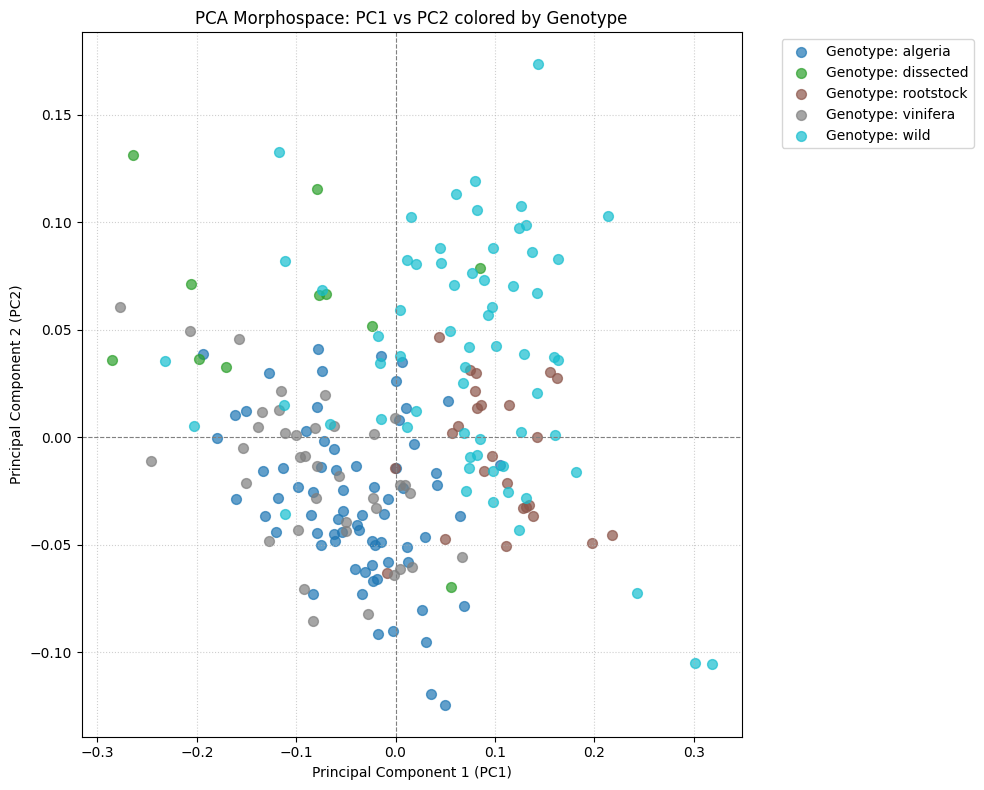

In [10]:
# Assume 'PCs' is your (210, 210) array of PCA scores
# Assume 'geno_labels' is your list of 210 genotype labels (same length as leaf_labels)

# --- Visualization Code Snippet ---

plt.figure(figsize=(10, 8)) # Adjust figure size as needed

# Get unique genotype labels and assign a distinct color to each
unique_labels = sorted(list(set(geno_labels))) # Using geno_labels here
cmap = plt.cm.get_cmap('tab10', len(unique_labels)) # 'tab10' is good for up to 10 distinct categories

for i, label in enumerate(unique_labels):
    # Find the indices corresponding to the current genotype label
    # Convert geno_labels to a NumPy array for efficient comparison if it's not already
    class_mask = (np.array(geno_labels) == label) # Using geno_labels here

    # Plot PC1 vs PC2 for this specific genotype
    plt.scatter(PCs[class_mask, 0], # PC1 scores for this genotype
                PCs[class_mask, 1], # PC2 scores for this genotype
                color=cmap(i),      # Assign a unique color
                label=f'Genotype: {label}', # Label for the legend, changed to 'Genotype'
                alpha=0.7,          # Slightly transparent points
                s=50)               # Marker size

plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('PCA Morphospace: PC1 vs PC2 colored by Genotype') # Title updated
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--') # Add horizontal line at 0
plt.axvline(0, color='gray', linewidth=0.8, linestyle='--') # Add vertical line at 0
plt.grid(True, linestyle=':', alpha=0.6) # Add a subtle grid
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside the plot area
plt.tight_layout() # Adjust layout to prevent labels/legend overlapping
plt.show()

_____________
# SAVE RESULTS FOR VEIN PREDICTION CNN  
dictionary: `leaf_indices`  
PCA model: `pca`  
PC scores: `PCs`  
class labels: `geno_labels`  
________________

In [11]:
# --- ASSUMPTION:
# - Your 'pca' object (e.g., from sklearn.decomposition.PCA) is already fitted.
# - Your 'leaf_indices' dictionary is already defined and populated.
# - Your 'PCs' array (PCA scores) is already defined and has shape (210, 210).
# - Your 'geno_labels' list is already defined and has length 210.

# --- 1. Define output directory and filenames ---
# MODIFIED: Changed output_dir to reflect the desired path structure
output_base_dir = "../outputs"
output_subdir = "saved_leaf_model_data"
output_full_path = os.path.join(output_base_dir, output_subdir)

pca_params_filename = os.path.join(output_full_path, "leaf_pca_model_parameters.h5")
leaf_indices_filename = os.path.join(output_full_path, "leaf_feature_indices.pkl")
pca_scores_and_labels_filename = os.path.join(output_full_path, "original_pca_scores_and_geno_labels.h5") # Renamed for clarity

# Create the output directory if it doesn't exist
os.makedirs(output_full_path, exist_ok=True)
print(f"Saving data to directory: {output_full_path}")

# --- 2. Extract information from the PCA model and original data ---
print("Extracting PCA model parameters, original scores, and genotype labels...")

# From the pca model object
pca_components = pca.components_          # Principal components (eigenvectors)
pca_mean = pca.mean_                      # Mean of the data PCA was fitted on
pca_explained_variance = pca.explained_variance_ # Actual variance (eigenvalues) per component (CRITICAL for sampling)
pca_explained_variance_ratio = pca.explained_variance_ratio_ # Proportion of variance explained
n_pca_components = pca.n_components_     # Number of components in the model

print(f"  PCA Components shape: {pca_components.shape}")
print(f"  PCA Mean shape: {pca_mean.shape}")
print(f"  PCA Explained Variance shape: {pca_explained_variance.shape}")
print(f"  PCA Explained Variance Ratio shape: {pca_explained_variance_ratio.shape}")
print(f"  Number of PCA components: {n_pca_components}")
print(f"  Original PCA Scores (PCs) shape: {PCs.shape}")
print(f"  Genotype Labels (geno_labels) length: {len(geno_labels)}")


# --- 3. Save the PCA model parameters to an HDF5 file ---
print(f"\nSaving PCA parameters to {pca_params_filename}...")
with h5py.File(pca_params_filename, 'w') as f:
    f.create_dataset('components', data=pca_components, compression="gzip")
    f.create_dataset('mean', data=pca_mean, compression="gzip")
    # Store BOTH explained_variance and explained_variance_ratio for completeness and sampling accuracy
    f.create_dataset('explained_variance', data=pca_explained_variance, compression="gzip")
    f.create_dataset('explained_variance_ratio', data=pca_explained_variance_ratio, compression="gzip")
    f.attrs['n_components'] = n_pca_components
print("PCA parameters saved successfully.")


# --- 4. Save the leaf_indices dictionary to a pickle file ---
print(f"\nSaving leaf feature indices to {leaf_indices_filename}...")
with open(leaf_indices_filename, 'wb') as f:
    pickle.dump(leaf_indices, f)
print("Leaf feature indices saved successfully.")


# --- 5. Save original PCA scores (PCs) and genotype labels (geno_labels) to an HDF5 file ---
print(f"\nSaving original PCA scores and genotype labels to {pca_scores_and_labels_filename}...")
with h5py.File(pca_scores_and_labels_filename, 'w') as f:
    f.create_dataset('pca_scores', data=PCs, compression="gzip")
    # --- FIX HERE: Convert geno_labels to a numpy array of byte strings ---
    # HDF5 handles fixed-length strings (S-type) or variable-length strings ('VLEN' string dtype).
    # Using 'S' for fixed-length byte strings is generally robust if lengths are consistent or padded.
    # .astype('S') converts Python unicode strings to NumPy byte strings.
    f.create_dataset('geno_labels', data=np.array(geno_labels).astype('S'), compression="gzip")
print("Original PCA scores and genotype labels saved successfully.")


# --- (Optional) Quick verification of loaded data ---
print("\n--- Verifying saved data (optional) ---")
# Load PCA parameters
with h5py.File(pca_params_filename, 'r') as f:
    loaded_components = f['components'][:]
    loaded_mean = f['mean'][:]
    loaded_explained_variance = f['explained_variance'][:]
    loaded_explained_variance_ratio = f['explained_variance_ratio'][:]
    loaded_n_components = f.attrs['n_components']

print(f"  Loaded PCA Components shape: {loaded_components.shape}")
print(f"  Loaded PCA Mean shape: {loaded_mean.shape}")
print(f"  Loaded PCA Explained Variance shape: {loaded_explained_variance.shape}")
print(f"  Loaded PCA Explained Variance Ratio shape: {loaded_explained_variance_ratio.shape}")

# Load leaf_indices
with open(leaf_indices_filename, 'rb') as f:
    loaded_leaf_indices = pickle.load(f)

print(f"  Loaded leaf_indices keys: {loaded_leaf_indices.keys()}")

# Load original PCA scores and labels
with h5py.File(pca_scores_and_labels_filename, 'r') as f:
    loaded_pca_scores = f['pca_scores'][:]
    loaded_geno_labels_bytes = f['geno_labels'][:] # Load as bytes

# --- Verification adjustment: Decode labels back to string for display ---
loaded_geno_labels = np.array([s.decode('utf-8') for s in loaded_geno_labels_bytes])

print(f"  Loaded Original PCA Scores shape: {loaded_pca_scores.shape}")
print(f"  Loaded Genotype Labels shape: {loaded_geno_labels.shape}")
print(f"  Example loaded geno_label (decoded): {loaded_geno_labels[0]} (Type: {type(loaded_geno_labels[0])})")


print("\nAll necessary data, including PCA model, leaf feature indices, original PCA scores, and genotype labels, have been extracted and saved successfully!")
print("This time, with the string type handled correctly for HDF5. You should be good to go!")

Saving data to directory: ../outputs/saved_leaf_model_data
Extracting PCA model parameters, original scores, and genotype labels...
  PCA Components shape: (210, 3344)
  PCA Mean shape: (3344,)
  PCA Explained Variance shape: (210,)
  PCA Explained Variance Ratio shape: (210,)
  Number of PCA components: 210
  Original PCA Scores (PCs) shape: (210, 210)
  Genotype Labels (geno_labels) length: 210

Saving PCA parameters to ../outputs/saved_leaf_model_data/leaf_pca_model_parameters.h5...
PCA parameters saved successfully.

Saving leaf feature indices to ../outputs/saved_leaf_model_data/leaf_feature_indices.pkl...
Leaf feature indices saved successfully.

Saving original PCA scores and genotype labels to ../outputs/saved_leaf_model_data/original_pca_scores_and_geno_labels.h5...
Original PCA scores and genotype labels saved successfully.

--- Verifying saved data (optional) ---
  Loaded PCA Components shape: (210, 3344)
  Loaded PCA Mean shape: (3344,)
  Loaded PCA Explained Variance shape

____________
# CHECK SAVED RESULTS
______________

--- Step 1: Loading all necessary data ---
Loaded PCA parameters from ../outputs/saved_leaf_model_data/leaf_pca_model_parameters.h5
Loaded leaf_indices from ../outputs/saved_leaf_model_data/leaf_feature_indices.pkl
Loaded original PCA scores and genotype labels from ../outputs/saved_leaf_model_data/original_pca_scores_and_geno_labels.h5
Data loaded successfully. Original PCA scores shape: (210, 210), Genotype labels length: 210

--- Step 2: Implementing SMOTE-like strategy ---

--- Step 5: Generating and Visualizing SMOTE-sampled leaves ---
Generating 1 general synthetic leaf...
  Generating SMOTE samples from all 210 original samples.


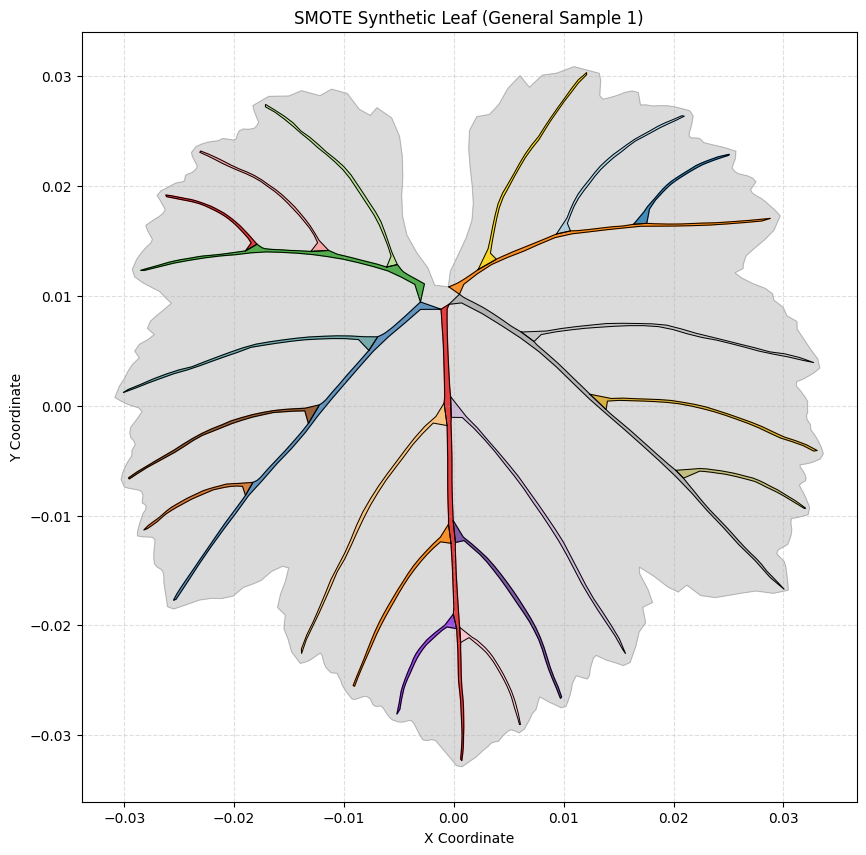

Generating 1 synthetic leaf targeting genotype 'algeria'...
  Generating SMOTE samples for target class: 'algeria' (71 samples)


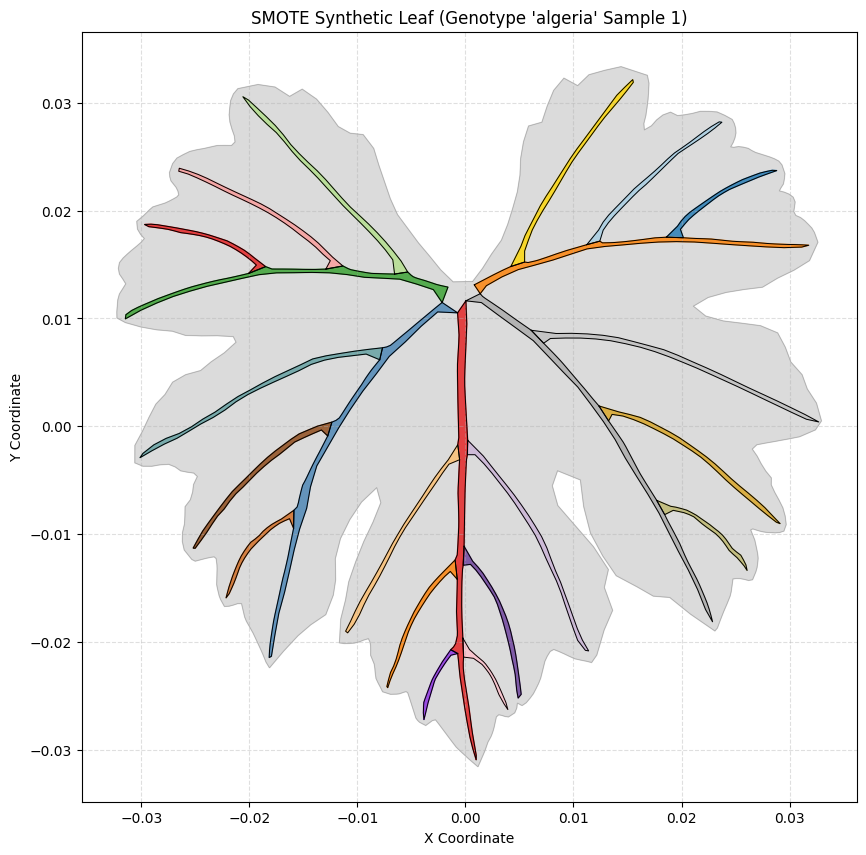


Finished generating and visualizing SMOTE-sampled leaves. We're on track!
You can now call 'generate_smote_samples' and 'reconstruct_leaf_from_pca_scores' with different parameters to create more synthetic leaves as needed.


In [12]:
# --- Step 1: Loading all necessary data ---
print("--- Step 1: Loading all necessary data ---")
# MODIFIED: Corrected output_dir to reflect the desired path structure
output_base_dir = "../outputs"
output_subdir = "saved_leaf_model_data"
output_full_path = os.path.join(output_base_dir, output_subdir)

pca_params_filename = os.path.join(output_full_path, "leaf_pca_model_parameters.h5")
leaf_indices_filename = os.path.join(output_full_path, "leaf_feature_indices.pkl")
pca_scores_and_labels_filename = os.path.join(output_full_path, "original_pca_scores_and_geno_labels.h5")

# Load PCA parameters
try:
    with h5py.File(pca_params_filename, 'r') as f:
        pca_components = f['components'][:]
        pca_mean = f['mean'][:]
        pca_explained_variance = f['explained_variance'][:]
        pca_explained_variance_ratio = f['explained_variance_ratio'][:]
        n_pca_components = f.attrs['n_components']
    print(f"Loaded PCA parameters from {pca_params_filename}")
except FileNotFoundError as e:
    print(f"Error loading PCA parameters: {e}. Please ensure the file exists at {pca_params_filename}.")
    raise

# Load leaf_indices
try:
    with open(leaf_indices_filename, 'rb') as f:
        leaf_indices = pickle.load(f)
    print(f"Loaded leaf_indices from {leaf_indices_filename}")
except FileNotFoundError as e:
    print(f"Error loading leaf_indices: {e}. Please ensure the file exists at {leaf_indices_filename}.")
    raise

# Load original PCA scores and genotype labels
try:
    with h5py.File(pca_scores_and_labels_filename, 'r') as f:
        original_pca_scores = f['pca_scores'][:]
        original_geno_labels_bytes = f['geno_labels'][:]
    # Decode byte strings back to Python strings for usability
    original_geno_labels = np.array([s.decode('utf-8') for s in original_geno_labels_bytes])
    print(f"Loaded original PCA scores and genotype labels from {pca_scores_and_labels_filename}")
except FileNotFoundError as e:
    print(f"Error loading PCA scores/labels: {e}. Please ensure the file exists at {pca_scores_and_labels_filename}.")
    raise

print(f"Data loaded successfully. Original PCA scores shape: {original_pca_scores.shape}, Genotype labels length: {len(original_geno_labels)}")


# --- Step 2: Implement SMOTE-like strategy for generating synthetic samples ---
print("\n--- Step 2: Implementing SMOTE-like strategy ---")

# Determine the original 2D coordinate shape (e.g., 1672, 2 points * 2 dimensions)
# This is derived from the length of the pca_mean vector, which is the flattened shape.
num_points_per_shape = pca_mean.shape[0] // 2


def generate_smote_samples(original_scores, labels, target_class=None,
                           k_neighbors=5, n_samples_to_generate=1, random_seed=None):
    """
    Generates synthetic samples using a SMOTE-like approach in PCA score space.

    Args:
        original_scores (np.ndarray): The PCA scores of your original samples (e.g., (210, n_components)).
        labels (np.ndarray or list): The class/genotype labels for original_scores.
        target_class (str/int, optional): If specified, only generates samples for this class.
                                          If None, uses all samples in original_scores.
        k_neighbors (int): Number of nearest neighbors to consider for each sample.
        n_samples_to_generate (int): Number of synthetic samples to generate in total.
        random_seed (int, optional): Seed for reproducibility.

    Returns:
        np.ndarray: A (n_samples_to_generate, n_components) array of synthetic PCA scores.
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    if target_class is not None:
        # Filter scores and labels for the target class
        class_mask = (np.array(labels) == target_class)
        samples_for_augmentation = original_scores[class_mask]
        print(f"  Generating SMOTE samples for target class: '{target_class}' ({len(samples_for_augmentation)} samples)")
    else:
        samples_for_augmentation = original_scores
        print(f"  Generating SMOTE samples from all {len(samples_for_augmentation)} original samples.")

    if len(samples_for_augmentation) < k_neighbors + 1:
        print(f"Warning: Not enough samples ({len(samples_for_augmentation)}) in the selected set for k_neighbors={k_neighbors}. Adjusting k to {max(1, len(samples_for_augmentation) - 1)}.")
        k_neighbors = max(1, len(samples_for_augmentation) - 1)
        if k_neighbors == 0: # This case means samples_for_augmentation was empty or had only 1 sample
            print("Error: No valid samples available for augmentation. Returning empty array.")
            return np.array([])
            
    synthetic_scores = []
    # Use NearestNeighbors to find neighbors in the PCA score space
    # k_neighbors + 1 because the sample itself is included as the first neighbor
    nn_model = NearestNeighbors(n_neighbors=k_neighbors + 1).fit(samples_for_augmentation)

    # Loop to generate the desired number of samples
    for _ in range(n_samples_to_generate):
        # 1. Randomly pick one sample (say, 's') from the set for augmentation
        idx_s = np.random.randint(0, len(samples_for_augmentation))
        s = samples_for_augmentation[idx_s]

        # 2. Find its k-nearest neighbors (including itself)
        # distances, indices = nn_model.kneighbors(s.reshape(1, -1))
        # From the returned indices, select one random neighbor *other than* 's' itself
        distances, neighbor_indices_full = nn_model.kneighbors(s.reshape(1, -1))
        
        # Ensure there are actual neighbors to choose from after excluding self
        if len(neighbor_indices_full[0]) <= 1:
            # This should ideally be caught by the k_neighbors adjustment above,
            # but as a safeguard.
            continue
            
        chosen_neighbor_idx_in_samples = np.random.choice(neighbor_indices_full[0][1:]) # [1:] excludes the sample itself
        chosen_neighbor = samples_for_augmentation[chosen_neighbor_idx_in_samples]

        # 3. Generate a random value (rho) between 0 and 1 for interpolation
        rho = np.random.uniform(0, 1)

        # 4. Create the new synthetic sample by interpolating between 's' and its chosen neighbor
        synthetic_sample_score = s + rho * (chosen_neighbor - s)
        synthetic_scores.append(synthetic_sample_score)

    return np.array(synthetic_scores)


# --- Step 3: Function to reconstruct 2D leaf coordinates from PCA scores ---

def reconstruct_leaf_from_pca_scores(pca_scores, pca_mean_vec, pca_components_matrix, original_coords_dim):
    """
    Reconstructs the 2D leaf shape from PCA scores.

    Args:
        pca_scores (np.ndarray): A (n_samples, n_components) array of PCA scores.
        pca_mean_vec (np.ndarray): The (n_features,) mean vector from PCA.
        pca_components_matrix (np.ndarray): The (n_components, n_features) principal components matrix.
        original_coords_dim (int): The number of original 2D coordinates per shape (e.g., 1672).

    Returns:
        np.ndarray: A (n_samples, original_coords_dim, 2) array of reconstructed 2D leaf coordinates.
    """
    # Ensure pca_scores is 2D, even if generating a single sample
    if pca_scores.ndim == 1:
        pca_scores = pca_scores.reshape(1, -1)

    # Reconstruction formula: original_data_flattened = mean + (scores @ components)
    # The result `reconstructed_flattened_shapes` will be an array of shape (n_samples, n_features_flattened)
    # where n_features_flattened is pca_mean_vec.shape[0]
    reconstructed_flattened_shapes = pca_mean_vec + np.dot(pca_scores, pca_components_matrix[:pca_scores.shape[1], :])

    # Reshape back to (n_samples, num_coords, 2)
    reconstructed_2d_shapes = reconstructed_flattened_shapes.reshape(-1, original_coords_dim, 2)
    return reconstructed_2d_shapes


# --- Step 4: Visualization Utility (re-using from previous steps) ---
# Define colors for different segments (copied for self-contained code)
colors = {
    "blade": '#D3D3D3',         # Light gray for the blade
    "mid_0": '#E41A1C',         # Red for midvein
    "left_prox_0": '#FF7F00', # Orange
    "left_prox_1": '#FFD700', # Gold
    "left_prox_2": '#A6CEE3', # Light blue
    "left_prox_3": '#1F78B4', # Darker blue

    "right_prox_0": '#33A02C', # Green
    "right_prox_1": '#B2DF8A', # Light green
    "right_prox_2": '#FB9A99', # Pink
    "right_prox_3": '#E31A1C', # Strong Red

    "left_mid_1": '#CAB2D6',  # Purple-ish
    "left_mid_2": '#6A3D9A',  # Dark purple
    "left_mid_3": '#FFC0CB',  # Light pink

    "right_mid_1": '#FDBF6F', # Light orange
    "right_mid_2": '#FF7F00', # Dark orange
    "right_mid_3": '#8A2BE2', # Blue-violet

    "left_dist_0": '#A9A9A9', # Dark gray
    "left_dist_1": '#C0C0C0', # Silver
    "left_dist_2": '#DAA520', # Goldenrod
    "left_dist_3": '#BDB76B', # Dark Khaki

    "right_dist_0": '#4682B4', # Steel Blue
    "right_dist_1": '#5F9EA0', # Cadet Blue
    "right_dist_2": '#8B4513', # Saddle Brown
    "right_dist_3": '#D2691E', # Chocolate
}

def plot_leaf_polygons(coords_2d, leaf_indices_dict, title="Synthetic Leaf Shape"):
    """
    Plots the leaf blade and vein polygons given 2D coordinates and indices.

    Args:
        coords_2d (np.ndarray): A (N, 2) array of coordinates.
        leaf_indices_dict (dict): Dictionary mapping segment names to lists of indices.
        title (str): Title for the plot.
    """
    plt.figure(figsize=(10, 10))
    ax = plt.gca()

    plot_order = ["blade"] + [key for key in leaf_indices_dict if key != "blade"]

    for key in plot_order:
        segment_indices_list = leaf_indices_dict.get(key)
        if not segment_indices_list:
            continue

        color = colors.get(key, '#808080')

        valid_indices = [idx for idx in segment_indices_list if 0 <= idx < coords_2d.shape[0]]
        if not valid_indices:
            # print(f"Warning: No valid indices for segment '{key}' polygon. Skipping visualization for this part.")
            continue

        polygon_coords = coords_2d[valid_indices]

        # Ensure the polygon is closed for plotting (first point equals last point)
        if not np.array_equal(polygon_coords[0], polygon_coords[-1]):
            polygon_coords = np.vstack([polygon_coords, polygon_coords[0]])

        if key == "blade":
            plt.fill(polygon_coords[:, 0], polygon_coords[:, 1],
                     color=color, alpha=0.8, label="Blade", zorder=0)
            plt.plot(polygon_coords[:, 0], polygon_coords[:, 1],
                     color='darkgray', linewidth=0.5, zorder=0)
        else:
            plt.fill(polygon_coords[:, 0], polygon_coords[:, 1],
                     color=color, alpha=0.8, label=key, zorder=1)
            plt.plot(polygon_coords[:, 0], polygon_coords[:, 1],
                     color='black', linewidth=0.7, zorder=2)

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title(title)
    plt.axis('equal') # Ensure aspect ratio is equal to avoid shape distortion
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.show()

# --- Step 5: Generate and Visualize a Few SMOTE-sampled Leaves ---
print("\n--- Step 5: Generating and Visualizing SMOTE-sampled leaves ---")

# Example 1: Generate a single synthetic leaf (from all samples, general augmentation)
print("Generating 1 general synthetic leaf...")
synthetic_scores_1 = generate_smote_samples(
    original_scores=original_pca_scores,
    labels=original_geno_labels, # Pass original labels (though not used if target_class is None)
    n_samples_to_generate=1,
    k_neighbors=5, # Using 5 nearest neighbors
    random_seed=100 # For reproducibility
)
if synthetic_scores_1.size > 0:
    # Reconstruct the 2D coordinates for the first (and only) generated sample
    synthetic_leaf_1_2d = reconstruct_leaf_from_pca_scores(
        synthetic_scores_1[0],
        pca_mean,
        pca_components,
        num_points_per_shape
    )
    plot_leaf_polygons(synthetic_leaf_1_2d[0], leaf_indices, "SMOTE Synthetic Leaf (General Sample 1)")
else:
    print("Could not generate general synthetic leaf.")

# Example 2: Generate another synthetic leaf, specifically targeting a genotype
# We'll use the first unique genotype found in your loaded data for this demonstration.
if len(np.unique(original_geno_labels)) > 0:
    sample_target_genotype = np.unique(original_geno_labels)[0] # Get the first unique genotype
    print(f"Generating 1 synthetic leaf targeting genotype '{sample_target_genotype}'...")
    synthetic_scores_2 = generate_smote_samples(
        original_scores=original_pca_scores,
        labels=original_geno_labels,
        target_class=sample_target_genotype, # Specify the target class
        n_samples_to_generate=1,
        k_neighbors=3, # Can use a different 'k' for specific class augmentation
        random_seed=200
    )
    if synthetic_scores_2.size > 0:
        # Reconstruct the 2D coordinates for the first (and only) generated sample
        synthetic_leaf_2_2d = reconstruct_leaf_from_pca_scores(
            synthetic_scores_2[0],
            pca_mean,
            pca_components,
            num_points_per_shape
        )
        plot_leaf_polygons(synthetic_leaf_2_2d[0], leaf_indices, f"SMOTE Synthetic Leaf (Genotype '{sample_target_genotype}' Sample 1)")
    else:
        print(f"Could not generate synthetic leaf for genotype '{sample_target_genotype}'.")
else:
    print("No unique genotypes found in the loaded data to demonstrate specific class augmentation.")

print("\nFinished generating and visualizing SMOTE-sampled leaves. We're on track!")
print("You can now call 'generate_smote_samples' and 'reconstruct_leaf_from_pca_scores' with different parameters to create more synthetic leaves as needed.")